In [1]:
import sys
import glob
import cv2
import numpy as np
import os

from shutil import copytree
from shutil import rmtree



import pickle
import math, re
from os import path

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, RMSprop
import matplotlib.pyplot as plt

import pandas as pd
import random
import shutil
import pathlib

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

path = "/content/drive/My Drive/DL course/HW4/"

!unzip 

Mounted at /content/drive/
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore a

## **Data preparation**

In this cell you're going to:
1.   Read images
2.   Preprocess them
3.   Create labels from the dirs.

Don't forget to create test, val and train sets

Split them appropriately

If you want to use **ImageDataGenerator** please write your final dataset in a directory


In [ ]:
images = []
labels = []

for root, dirs, files in os.walk(path + "data/dataset/"):
    print(os.path.basename(root))
    label = os.path.basename(root)

    for file_ in files:
        full_file_path = os.path.join(root, file_)
        img = cv2.imread(full_file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        s = img.shape
        if s[0] < 300 or s[1] < 300:
            continue
        images.append(img[:300, :300])
        labels.append(label)


mazda_3
kia_cerato
peugeot_206
saipa_saina
iranKhodro_dena


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train[6].shape

(300, 300, 3)

In [ ]:
X_train = [X_train]

In [ ]:
X_train = np.concatenate(X_train, axis=0 )

In [ ]:
X_train.shape

(1254, 300, 300, 3)

In [8]:
#####################################
##### Your implementation here ######



#####################################

Found 2102 images belonging to 5 classes.


## **Define global variable**

Feel free to change them

In [3]:
num_classes = 5
EPOCHS = 150
BATCH_SIZE = 20

BASE_FOLDER = './data/'

## **Create your own CNN model**

In [ ]:
def create_cnn_model():
  '''
  In this function you should create your CNN model and define layers
  via Sequential or Functional API
  
  Feel free to set hyperparameters of model as you desired

  Then compile your model and define optimizer ans loss function

  Please set your metrices to monitor the accuracy

  At the end of the code please print the summary of the model

  Arguments:
  output: created model
  '''
  #####################################
  ##### Your implementation here ######

  model = Sequential([
                    layers.Conv2D(16,3,padding='SAME',activation="relu",input_shape=(224,224,3)),
                    layers.MaxPooling2D(2),
                    layers.Conv2D(32,3,padding='SAME',activation="relu"),
                    layers.MaxPooling2D(2),
                    # layers.Conv2D(64,3,padding='SAME',activation="relu"),
                    # layers.MaxPooling2D(2),
                    layers.Flatten(),
                    layers.Dense(32,activation="relu"),
                    layers.Dense(5,activation="softmax")
  ])

  
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print(model.summary())


  #####################################
  return model
  

In [13]:
def create_callbacks():
  '''
  We prefer use three of the callbacks in the keras API

  1. early stopping: take a look at https://keras.io/api/callbacks/early_stopping/
  2. reduce_lr: take a look at https://keras.io/api/callbacks/reduce_lr_on_plateau/
  3. model_checkpoints: take a look at https://keras.io/api/callbacks/model_checkpoint/

  Arguments:
    output: a list of callbacks

  '''
  #####################################
  ##### Your implementation here ######  
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      'models/my_model.hdf5',
      monitor="val_accuracy",
      save_best_only=True)

  callbacks = [
      callback,
      reduce_lr,
      model_checkpoint_callback
  ]


  #####################################

  return callbacks

In [14]:
def train_model_naive_split():
  '''
  We need to first read our stored data then fit our created model with provided callbacks

  For this use the https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator function

  You can load your data in a way you feel comfortable and there is no force to use this methods

  outputs: The History of the training process
  '''
  #####################################
  ##### Your implementation here ######  

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=5,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      brightness_range=[0.2,0.8])

  train_generator = train_datagen.flow_from_directory(directory=path + "data/train/",
                                                      target_size=(224, 224),
                                                      color_mode="rgb",
                                                      batch_size=32,
                                                      class_mode="categorical",
                                                      shuffle=True,
                                                      seed=42
                                                  )

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=path + "data/validation/",
                                                                target_size=(224, 224),
                                                                color_mode="rgb",
                                                                batch_size=32,
                                                                class_mode="categorical",
                                                                shuffle=True,
                                                                seed=42
                                                            )

  model = create_cnn_model()

  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size


  history =  model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=validation_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=50,
                                  verbose=2,
                                  callbacks=create_callbacks()
                                )

  #####################################

  return history

In [15]:
## Train the model

history = train_model_naive_split()

Found 1622 images belonging to 5 classes.
Found 225 images belonging to 5 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                     

<ipython-input-14-22f87df72833>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =  model.fit_generator(generator=train_generator,


Epoch 1/50
50/50 - 31s - loss: 1.6675 - accuracy: 0.2358 - val_loss: 1.8711 - val_accuracy: 0.1696 - lr: 0.0010 - 31s/epoch - 622ms/step
Epoch 2/50
50/50 - 30s - loss: 1.5961 - accuracy: 0.2472 - val_loss: 1.5947 - val_accuracy: 0.2366 - lr: 0.0010 - 30s/epoch - 603ms/step
Epoch 3/50
50/50 - 30s - loss: 1.5775 - accuracy: 0.2843 - val_loss: 1.6275 - val_accuracy: 0.2277 - lr: 0.0010 - 30s/epoch - 606ms/step
Epoch 4/50
50/50 - 31s - loss: 1.5623 - accuracy: 0.2855 - val_loss: 1.5990 - val_accuracy: 0.2455 - lr: 0.0010 - 31s/epoch - 624ms/step
Epoch 5/50
50/50 - 30s - loss: 1.5471 - accuracy: 0.3088 - val_loss: 1.6096 - val_accuracy: 0.2768 - lr: 0.0010 - 30s/epoch - 610ms/step
Epoch 6/50
50/50 - 31s - loss: 1.5405 - accuracy: 0.3201 - val_loss: 1.5918 - val_accuracy: 0.2634 - lr: 0.0010 - 31s/epoch - 610ms/step
Epoch 7/50
50/50 - 30s - loss: 1.5423 - accuracy: 0.2981 - val_loss: 1.5998 - val_accuracy: 0.2768 - lr: 0.0010 - 30s/epoch - 609ms/step
Epoch 8/50
50/50 - 31s - loss: 1.5239 - a

In [16]:
  type(history)

keras.callbacks.History

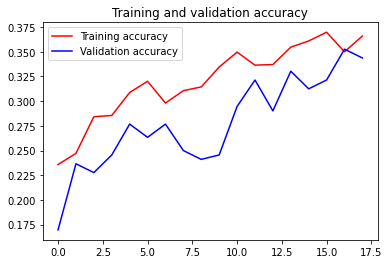

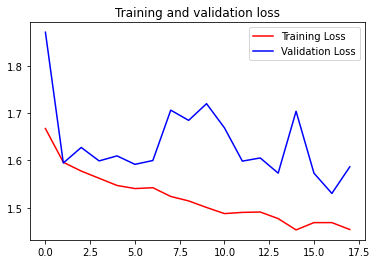

In [16]:
## just run the bellow cell and see the acc and loss plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
def load_and_predict(model, path):
  '''
  This function is used to generate the models predictions on test data

  If you loaded your data in other way please change the function to produce your predictions correctly

  If not, just run the cell
  '''
  test_generator = ImageDataGenerator(rescale=1. / 255)

  test_iterator = test_generator.flow_from_directory(
        path,
        target_size=(224, 224),
        shuffle=False,
        class_mode='categorical',
        batch_size=1) 

  ids = []
  for filename in test_iterator.filenames:
    print(filename)
    ids.append(filename)

  predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
  predictions = []
  for index, prediction in enumerate(predict_result):
    classes = np.argmax(prediction)
    predictions.append([ids[index], classes])
  predictions.sort()

  return predictions

In [18]:
def store_prediction(model_path, test_data_path, result_path):
  '''
  A function to run the load and predict function

  just run the cell
  '''
  model = keras.models.load_model(model_path, compile = True)

  predictions = load_and_predict(model, test_data_path)

  df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
  df = df.set_index(['image_id'])

  print(df.head())
  print('Writing submission')
  df.to_csv(result_path)

In [23]:
store_prediction('./models/my_model.hdf5', path + 'data/test/', './results.csv')

Found 255 images belonging to 5 classes.
iranKhodro_dena/1.jpg
iranKhodro_dena/10.jpg
iranKhodro_dena/11.jpg
iranKhodro_dena/12.jpg
iranKhodro_dena/13.jpg
iranKhodro_dena/14.jpg
iranKhodro_dena/15.jpg
iranKhodro_dena/16.jpg
iranKhodro_dena/17.jpg
iranKhodro_dena/18.jpg
iranKhodro_dena/19.jpg
iranKhodro_dena/2.jpg
iranKhodro_dena/20.jpg
iranKhodro_dena/21.jpg
iranKhodro_dena/22.jpg
iranKhodro_dena/23.jpg
iranKhodro_dena/24.jpg
iranKhodro_dena/25.jpg
iranKhodro_dena/26.jpg
iranKhodro_dena/27.jpg
iranKhodro_dena/28.jpg
iranKhodro_dena/29.jpg
iranKhodro_dena/3.jpg
iranKhodro_dena/30.jpg
iranKhodro_dena/31.jpg
iranKhodro_dena/32.jpg
iranKhodro_dena/33.jpg
iranKhodro_dena/34.jpg
iranKhodro_dena/35.jpg
iranKhodro_dena/36.jpg
iranKhodro_dena/37.jpg
iranKhodro_dena/38.jpg
iranKhodro_dena/39.jpg
iranKhodro_dena/4.jpg
iranKhodro_dena/40.jpg
iranKhodro_dena/41.jpg
iranKhodro_dena/42.jpg
iranKhodro_dena/43.jpg
iranKhodro_dena/44.jpg
iranKhodro_dena/45.jpg
iranKhodro_dena/46.jpg
iranKhodro_dena/47.j

Here your own CNN model implementation has done

## **Transfer learning from a pre-trained model**

This implementation is as the same to the previous one except in the model creation and training sections

So use the other ones for code simplicity 

In [24]:
def create_cnn_model():
  from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
  '''
  In this function you need to implement a cnn model from pre-trained one

  We recommand use the MobileNetV2 network

  See the bellow link:

  https://keras.io/api/applications/mobilenet/

  don't forget to fine-tune the last layer

  Use the imagenet weights

  '''
  #####################################
  ##### Your implementation here ######    
  MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                            alpha=1.0,
                                            include_top=False,
                                            weights="imagenet",
                                            input_tensor=None,
                                            pooling=None,
                                            classes=5,
                                            classifier_activation="softmax",
                                        )
  
  model = Sequential()
  model.add(MobileNetV2)
  model.add(layers.Flatten())
  model.add(layers.Dense(5, activation='softmax'))
  

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print(model.summary())

  #####################################
  return model

In [25]:
## train the model but don't forget adapte the hyper-parameters

history=train_model_naive_split()

Found 1622 images belonging to 5 classes.
Found 225 images belonging to 5 classes.
9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_8 (Dense)             (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 2,537,477
Non-trainable params: 34,112
_________________________________________________________________
None


<ipython-input-14-22f87df72833>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =  model.fit_generator(generator=train_generator,


Epoch 1/50
50/50 - 94s - loss: 2.1567 - accuracy: 0.4698 - val_loss: 50.5749 - val_accuracy: 0.2232 - lr: 0.0010 - 94s/epoch - 2s/step
Epoch 2/50
50/50 - 33s - loss: 1.9894 - accuracy: 0.6673 - val_loss: 57.5789 - val_accuracy: 0.2232 - lr: 0.0010 - 33s/epoch - 658ms/step
Epoch 3/50
50/50 - 33s - loss: 2.1181 - accuracy: 0.6119 - val_loss: 65.3449 - val_accuracy: 0.2232 - lr: 0.0010 - 33s/epoch - 660ms/step
Epoch 4/50
50/50 - 33s - loss: 2.6260 - accuracy: 0.5308 - val_loss: 72.3259 - val_accuracy: 0.2232 - lr: 0.0010 - 33s/epoch - 661ms/step
Epoch 5/50
50/50 - 33s - loss: 2.3464 - accuracy: 0.5711 - val_loss: 47.8842 - val_accuracy: 0.2232 - lr: 0.0010 - 33s/epoch - 667ms/step
50/50 - 33s - loss: 2.3464 - accuracy: 0.5711 - val_loss: 47.8842 - val_accuracy: 0.2232 - lr: 0.0010 - 33s/epoch - 667ms/step


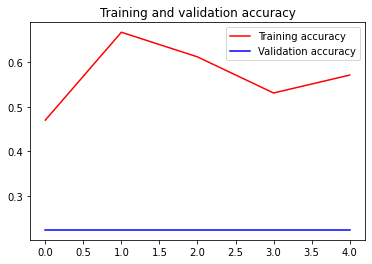

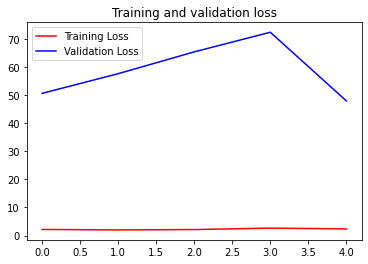

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
store_prediction('./models/my_model.hdf5', path + 'data/test/', './results.csv')

Found 255 images belonging to 5 classes.
iranKhodro_dena/1.jpg
iranKhodro_dena/10.jpg
iranKhodro_dena/11.jpg
iranKhodro_dena/12.jpg
iranKhodro_dena/13.jpg
iranKhodro_dena/14.jpg
iranKhodro_dena/15.jpg
iranKhodro_dena/16.jpg
iranKhodro_dena/17.jpg
iranKhodro_dena/18.jpg
iranKhodro_dena/19.jpg
iranKhodro_dena/2.jpg
iranKhodro_dena/20.jpg
iranKhodro_dena/21.jpg
iranKhodro_dena/22.jpg
iranKhodro_dena/23.jpg
iranKhodro_dena/24.jpg
iranKhodro_dena/25.jpg
iranKhodro_dena/26.jpg
iranKhodro_dena/27.jpg
iranKhodro_dena/28.jpg
iranKhodro_dena/29.jpg
iranKhodro_dena/3.jpg
iranKhodro_dena/30.jpg
iranKhodro_dena/31.jpg
iranKhodro_dena/32.jpg
iranKhodro_dena/33.jpg
iranKhodro_dena/34.jpg
iranKhodro_dena/35.jpg
iranKhodro_dena/36.jpg
iranKhodro_dena/37.jpg
iranKhodro_dena/38.jpg
iranKhodro_dena/39.jpg
iranKhodro_dena/4.jpg
iranKhodro_dena/40.jpg
iranKhodro_dena/41.jpg
iranKhodro_dena/42.jpg
iranKhodro_dena/43.jpg
iranKhodro_dena/44.jpg
iranKhodro_dena/45.jpg
iranKhodro_dena/46.jpg
iranKhodro_dena/47.j

## **Grad-CAM**
For some random images from different classes, show the heatmaps based on the grad-cam algorithm that you have learned.